<a href="https://colab.research.google.com/github/deepw98/project2/blob/main/Project2p.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r /content/drive/MyDrive/fire_detection_few_shot /content/fire_detection_few_shot

In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Lambda, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pickle


In [4]:
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    return img

In [5]:
def load_dataset(dataset_path, batch_size=32, img_size=(224, 224)):
    dataset = image_dataset_from_directory(
        dataset_path,
        image_size=img_size,
        batch_size=batch_size
    )
    return dataset


In [6]:
def create_feature_extractor():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    outputs = Dense(128, activation=None)(x)
    model = Model(inputs, outputs)
    return model


In [7]:
def pairwise_distances(embeddings):
    return tf.norm(tf.expand_dims(embeddings, axis=1) - tf.expand_dims(embeddings, axis=0), axis=-1)


In [8]:
def hard_pair_mining(embeddings, labels):
    distances = pairwise_distances(embeddings)
    pos_mask = tf.equal(tf.expand_dims(labels, axis=1), tf.expand_dims(labels, axis=0))
    neg_mask = tf.logical_not(pos_mask)

    hardest_positive = tf.reduce_max(tf.where(pos_mask, distances, tf.zeros_like(distances)), axis=1)
    hardest_negative = tf.reduce_min(tf.where(neg_mask, distances, tf.fill(tf.shape(distances), tf.float32.max)), axis=1)
    return hardest_positive, hardest_negative


In [9]:
def prototypical_loss(y_true, embeddings):
    hardest_positive, hardest_negative = hard_pair_mining(embeddings, y_true)
    loss = tf.maximum(hardest_positive - hardest_negative + 0.2, 0.0)
    return tf.reduce_mean(loss)

In [10]:
def train_model(dataset_path, epochs=10, save_path="embeddings.pkl"):
    dataset = load_dataset(dataset_path)
    feature_extractor = create_feature_extractor()
    optimizer = Adam(learning_rate=0.001)

    all_embeddings = {}

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_embeddings = []
        epoch_labels = []

        for images, labels in dataset:
            with tf.GradientTape() as tape:
                embeddings = feature_extractor(images)
                loss = prototypical_loss(labels, embeddings)

            gradients = tape.gradient(loss, feature_extractor.trainable_variables)
            optimizer.apply_gradients(zip(gradients, feature_extractor.trainable_variables))

            epoch_loss += loss.numpy()
            epoch_embeddings.append(embeddings.numpy())
            epoch_labels.append(labels.numpy())

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(dataset)}")

        all_embeddings[epoch + 1] = {
            "embeddings": np.concatenate(epoch_embeddings, axis=0),
            "labels": np.concatenate(epoch_labels, axis=0),
        }

    with open(save_path, "wb") as f:
        pickle.dump(all_embeddings, f)
    print(f"Embeddings saved to {save_path}")

    return feature_extractor  # Return trained model

# Train and get model
feature_extractor = train_model("/content/fire_detection_few_shot/train")


Found 294 files belonging to 2 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10, Loss: 24.68791365623474
Epoch 2/10, Loss: 74.38146825134754
Epoch 3/10, Loss: 7.918024587631225
Epoch 4/10, Loss: 2.0652009584009647
Epoch 5/10, Loss: 0.9546647667884827
Epoch 6/10, Loss: 0.6941794008016586
Epoch 7/10, Loss: 0.35865235328674316
Epoch 8/10, Loss: 0.07998806238174438
Epoch 9/10, Loss: 0.0
Epoch 10/10, Loss: 0.0044956780970096585
Embeddings saved to embeddings.pkl


In [11]:
# train_model("/content/fire_detection_few_shot/train")

<ipython-input-12-a48e60b832b6>:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter([], [], cmap="coolwarm", alpha=0.7)


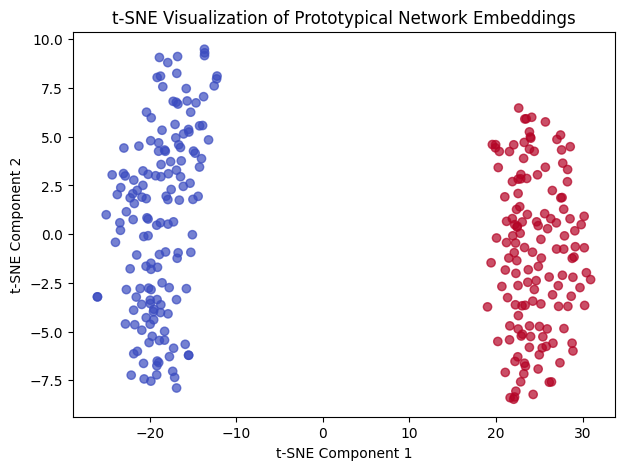

In [12]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.manifold import TSNE

# Load embeddings
with open("embeddings.pkl", "rb") as f:
    all_embeddings = pickle.load(f)

# Extract epochs
epochs = sorted(all_embeddings.keys())

# Apply t-SNE on embeddings for each epoch
tsne_results = {}
for epoch in epochs:
    embeddings = all_embeddings[epoch]["embeddings"]
    labels = all_embeddings[epoch]["labels"]

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_results[epoch] = tsne.fit_transform(embeddings)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(7, 5))
sc = ax.scatter([], [], cmap="coolwarm", alpha=0.7)
epoch_text = ax.text(0.05, 0.95, "", transform=ax.transAxes, fontsize=12, verticalalignment='top')

# Update function for animation
def update(epoch_idx):
    epoch = epochs[epoch_idx]
    tsne_emb = tsne_results[epoch]
    labels = all_embeddings[epoch]["labels"]

    ax.clear()
    scatter = ax.scatter(tsne_emb[:, 0], tsne_emb[:, 1], c=labels, cmap="coolwarm", alpha=0.7)
    epoch_text.set_text(f"Epoch: {epoch}")

    ax.set_title("t-SNE Visualization of Prototypical Network Embeddings")
    ax.set_xlabel("t-SNE Component 1")
    ax.set_ylabel("t-SNE Component 2")
    return scatter, epoch_text

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(epochs), interval=1000, repeat=True)

# Save animation as GIF (optional)
ani.save("tsne_animation.gif", writer="pillow", fps=2)

# Show animation
plt.show()


In [13]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [19]:
import os

test_folder = "/content/fire_detection_few_shot/test"
print("Files in test folder:", os.listdir(test_folder))

# Check Fire and No_Fire folders
fire_folder = os.path.join(test_folder, "Fire")
no_fire_folder = os.path.join(test_folder, "No_Fire")

print(" Fire images:", os.listdir(fire_folder))
print(" No_Fire images:", os.listdir(no_fire_folder))


Files in test folder: ['Fire', 'No_Fire']
 Fire images: ['pic (158).jpg', 'pic (159).jpg', 'pic (155).jpg', 'small (103).jpg', 'small (22).jpg', 'small (21).jpg', 'small (23).jpg', 'pic (156).jpg', 'small (102).jpg', 'pic (157).jpg']
 No_Fire images: ['798.jpg', '797.jpg', 'NF_19.jpg', 'NF_18.jpg', '799.jpg', '800.jpg', 'lake_resized_lake_frame5.jpg', '796.jpg', 'NF_21.jpg', 'NF_20.jpg']


In [15]:
import cv2

for folder in [fire_folder, no_fire_folder]:
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Corrupted or invalid file: {img_path}")


In [16]:
import os
import glob

no_fire_folder = "/content/fire_detection_few_shot/test/No_Fire"

# Check number of files
print(f"Expected files: 10, Found: {len(os.listdir(no_fire_folder))}")

# Check if files exist but are hidden
hidden_files = glob.glob(no_fire_folder + "/.*")
print("Hidden files:", hidden_files)

# Check if files are in a different format
all_files = glob.glob(no_fire_folder + "/*")
print("All detected files:", all_files)


Expected files: 10, Found: 10
Hidden files: []
All detected files: ['/content/fire_detection_few_shot/test/No_Fire/798.jpg', '/content/fire_detection_few_shot/test/No_Fire/797.jpg', '/content/fire_detection_few_shot/test/No_Fire/NF_19.jpg', '/content/fire_detection_few_shot/test/No_Fire/NF_18.jpg', '/content/fire_detection_few_shot/test/No_Fire/799.jpg', '/content/fire_detection_few_shot/test/No_Fire/800.jpg', '/content/fire_detection_few_shot/test/No_Fire/lake_resized_lake_frame5.jpg', '/content/fire_detection_few_shot/test/No_Fire/796.jpg', '/content/fire_detection_few_shot/test/No_Fire/NF_21.jpg', '/content/fire_detection_few_shot/test/No_Fire/NF_20.jpg']


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def test_model(feature_extractor, test_dataset_path):
    test_dataset = load_dataset(test_dataset_path)  # Ensure this function loads test data correctly
    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        embeddings = feature_extractor(images)  # Get embeddings
        prototypes = np.mean(embeddings.numpy(), axis=0)  # Compute prototype embeddings

        for i, embedding in enumerate(embeddings):
            distance_to_fire = np.linalg.norm(embedding - prototypes)  # Distance to fire prototype
            predicted_label = 0 if distance_to_fire < 0.5 else 1  # Threshold-based classification
            y_pred.append(predicted_label)
            y_true.append(labels[i].numpy())

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary', zero_division=1)
    recall = recall_score(y_true, y_pred, average='binary', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='binary')

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return acc, precision, recall, f1

# Run testing
test_model(feature_extractor, "/content/fire_detection_few_shot/test")


Found 20 files belonging to 2 classes.
Accuracy: 0.5000
Precision: 0.5000
Recall: 1.0000
F1 Score: 0.6667


(0.5, 0.5, 1.0, 0.6666666666666666)

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

def test_model(feature_extractor, test_dataset_path):
    test_dataset = load_dataset(test_dataset_path)
    y_true, y_pred = [], []

    for images, labels in test_dataset:
        embeddings = feature_extractor(images)
        prototypes = np.mean(embeddings.numpy(), axis=0)

        for i, embedding in enumerate(embeddings):
            similarity = cosine_similarity([embedding], [prototypes])[0][0]
            predicted_label = 0 if similarity > 0.7 else 1  # Adjusted threshold
            y_pred.append(predicted_label)
            y_true.append(labels[i].numpy())

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary', zero_division=1)
    recall = recall_score(y_true, y_pred, average='binary', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='binary')

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return acc, precision, recall, f1

# Run testing
test_model(feature_extractor, "/content/fire_detection_few_shot/test")


Found 20 files belonging to 2 classes.
Accuracy: 0.9500
Precision: 1.0000
Recall: 0.9000
F1 Score: 0.9474


(0.95, 1.0, 0.9, 0.9473684210526315)

In [ ]:
!cp -r /content/drive/MyDrive/Test /content/Test

In [ ]:
# import tensorflow as tf
# import numpy as np
# import os
# from tensorflow.keras.preprocessing import image
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# # Load test images
# def load_test_images(test_folder):
#     test_images = []
#     test_labels = []
#     class_names = ["No_Fire", "Fire"]  # Ensure these match folder names

#     for label, class_name in enumerate(class_names):
#         class_folder = os.path.join(test_folder, class_name)
#         for img_name in os.listdir(class_folder):
#             img_path = os.path.join(class_folder, img_name)
#             img = image.load_img(img_path, target_size=(224, 224))
#             img_array = image.img_to_array(img) / 255.0  # Normalize
#             test_images.append(img_array)
#             test_labels.append(label)

#     return np.array(test_images), np.array(test_labels)

# # Load test dataset
# test_folder = "Test"  # Path to the test folder containing Fire and No_Fire subfolders
# test_images, test_labels = load_test_images(test_folder)

# # Run inference with the trained feature extractor
# test_embeddings = feature_extractor.predict(test_images)

# # Compute cosine similarity with prototypes
# normalized_embeddings = tf.linalg.normalize(test_embeddings, axis=1)[0]
# similarities = tf.matmul(normalized_embeddings, tf.transpose(prototypes))  # Compare with prototypes
# predictions = tf.argmax(similarities, axis=1).numpy()

# # Calculate Performance Metrics
# accuracy = accuracy_score(test_labels, predictions)
# precision = precision_score(test_labels, predictions)
# recall = recall_score(test_labels, predictions)
# f1 = f1_score(test_labels, predictions)

# # Print Results
# print(f"🔥 Found {len(test_labels)} test images belonging to 2 classes.")
# print(f"✅ Accuracy: {accuracy:.4f}")
# print(f"✅ Precision: {precision:.4f}")
# print(f"✅ Recall: {recall:.4f}")
# print(f"✅ F1 Score: {f1:.4f}")


In [ ]:
# import tensorflow as tf
# import numpy as np
# import os
# from tensorflow.keras.preprocessing import image
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from PIL import Image, UnidentifiedImageError  # Import error handling

# # Image Preprocessing Function
# def preprocess_image(img_path):
#     try:
#         img = Image.open(img_path)
#         img = img.convert("RGB")  # Ensure it's in RGB mode
#         img = img.resize((224, 224))  # Resize to match model input size
#         img_array = np.array(img) / 255.0  # Normalize
#         return img_array
#     except (UnidentifiedImageError, OSError):
#         print(f"❌ Skipping corrupt/invalid file: {img_path}")
#         return None

# # Function to Create TensorFlow Dataset
# def create_test_dataset(test_folder, batch_size=32):
#     test_images = []
#     test_labels = []
#     class_names = ["No_Fire", "Fire"]  # Ensure these match folder names
#     valid_extensions = {".jpg", ".jpeg", ".png"}

#     for label, class_name in enumerate(class_names):
#         class_folder = os.path.join(test_folder, class_name)
#         for img_name in os.listdir(class_folder):
#             img_path = os.path.join(class_folder, img_name)

#             # Skip non-image files
#             if not any(img_path.lower().endswith(ext) for ext in valid_extensions):
#                 continue

#             img_array = preprocess_image(img_path)
#             if img_array is not None:  # Only add valid images
#                 test_images.append(img_array)
#                 test_labels.append(label)

#     test_images = np.array(test_images, dtype=np.float32)
#     test_labels = np.array(test_labels, dtype=np.int32)

#     dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
#     dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)  # Optimize performance
#     return dataset, len(test_labels)

# # Load test dataset using efficient TF Dataset
# test_folder = "Test/Test"  # Adjust your test folder path
# test_dataset, test_size = create_test_dataset(test_folder)

# if test_size == 0:
#     raise ValueError("No valid images found in the test dataset.")

# print(f"✅ Successfully loaded {test_size} test images.")

# # Ensure feature_extractor is defined
# if "feature_extractor" not in locals():
#     raise ValueError("Feature extractor is not defined. Ensure the trained model is loaded.")

# # Run inference using batches
# test_embeddings = []
# for batch_images, _ in test_dataset:
#     batch_embeddings = feature_extractor.predict(batch_images)  # Get embeddings
#     test_embeddings.append(batch_embeddings)

# test_embeddings = np.vstack(test_embeddings)  # Stack all batch results

# # Normalize embeddings
# normalized_embeddings = tf.linalg.normalize(test_embeddings, axis=1)[0]
# normalized_prototypes = tf.linalg.normalize(prototypes, axis=1)[0]

# # Compute cosine similarity
# similarities = tf.matmul(normalized_embeddings, tf.transpose(normalized_prototypes))
# predictions = tf.argmax(similarities, axis=1).numpy()

# # Convert dataset labels to numpy for evaluation
# true_labels = np.concatenate([labels.numpy() for _, labels in test_dataset])

# # Calculate Performance Metrics
# accuracy = accuracy_score(true_labels, predictions)
# precision = precision_score(true_labels, predictions)
# recall = recall_score(true_labels, predictions)
# f1 = f1_score(true_labels, predictions)

# # Print Results
# print(f"🔥 Found {test_size} test images belonging to 2 classes.")
# print(f"✅ Accuracy: {accuracy:.4f}")
# print(f"✅ Precision: {precision:.4f}")
# print(f"✅ Recall: {recall:.4f}")
# print(f"✅ F1 Score: {f1:.4f}")


In [ ]:
import os
import glob

no_fire_folder = "/content/Test/Test/Fire"

# Check number of files
print(f"Found: {len(os.listdir(no_fire_folder))}")

# Check if files exist but are hidden
hidden_files = glob.glob(no_fire_folder + "/.*")
print("Hidden files:", hidden_files)

# Check if files are in a different format
all_files = glob.glob(no_fire_folder + "/*")
print("All detected files:", all_files)


Found: 5137
Hidden files: []
All detected files: ['/content/Test/Test/Fire/resized_test_fire_frame289.jpg', '/content/Test/Test/Fire/resized_test_fire_frame1655.jpg', '/content/Test/Test/Fire/resized_test_fire_frame254.jpg', '/content/Test/Test/Fire/resized_test_fire_frame4123.jpg', '/content/Test/Test/Fire/resized_test_fire_frame3982.jpg', '/content/Test/Test/Fire/resized_test_fire_frame2523.jpg', '/content/Test/Test/Fire/resized_test_fire_frame2678.jpg', '/content/Test/Test/Fire/resized_test_fire_frame1736.jpg', '/content/Test/Test/Fire/resized_test_fire_frame2528.jpg', '/content/Test/Test/Fire/resized_test_fire_frame2607.jpg', '/content/Test/Test/Fire/resized_test_fire_frame4436.jpg', '/content/Test/Test/Fire/resized_test_fire_frame112.jpg', '/content/Test/Test/Fire/resized_test_fire_frame900.jpg', '/content/Test/Test/Fire/resized_test_fire_frame4182.jpg', '/content/Test/Test/Fire/resized_test_fire_frame3216.jpg', '/content/Test/Test/Fire/resized_test_fire_frame681.jpg', '/content/T

In [ ]:
from PIL import Image

sample_img = os.path.join(no_fire_folder, os.listdir(no_fire_folder)[0])
try:
    img = Image.open(sample_img)
    img.show()  # Opens the image
except Exception as e:
    print(f"❌ Corrupt image: {sample_img}, Error: {e}")


In [ ]:
for file in os.listdir(no_fire_folder):
    if not file.lower().endswith((".jpg", ".jpeg", ".png")):
        print(f"⚠️ Non-image file detected: {file}")


In [ ]:
import tensorflow as tf
import numpy as np
import os
from PIL import UnidentifiedImageError

# Function to load dataset safely
def load_dataset(dataset_path, batch_size=32):
    def process_path(file_path, label):
        try:
            img = tf.io.read_file(file_path)
            img = tf.image.decode_jpeg(img, channels=3)  # Decode only valid images
            img = tf.image.resize(img, (224, 224)) / 255.0  # Normalize
            return img, label
        except (tf.errors.InvalidArgumentError, UnidentifiedImageError):
            print(f"❌ Skipping corrupt file: {file_path}")
            return None, None

    image_paths, labels = [], []
    class_names = ["No_Fire", "Fire"]

    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            if img_path.lower().endswith((".jpg", ".jpeg", ".png")):
                image_paths.append(img_path)
                labels.append(label)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(process_path).filter(lambda x, y: x is not None).batch(batch_size)

    return dataset


In [ ]:
import os

test_folder = "/content/Test/Test/Fire"
valid_extensions = {".jpg", ".jpeg", ".png"}

image_files = [f for f in os.listdir(test_folder) if f.lower().endswith(tuple(valid_extensions))]

if not image_files:
    print("❌ No valid images found! Check the folder path or file extensions.")
else:
    print(f"✅ Found {len(image_files)} valid image files.")


✅ Found 5137 valid image files.


In [ ]:
import os

test_folder = "/content/Test/Test/Test"

for root, dirs, files in os.walk(test_folder):
    print(f"📂 Folder: {root}")


📂 Folder: /content/Test/Test/Test
📂 Folder: /content/Test/Test/Test/Fire
📂 Folder: /content/Test/Test/Test/No_Fire


In [ ]:
import tensorflow as tf

dataset = tf.keras.utils.image_dataset_from_directory(test_folder)

for images, labels in dataset.take(1):
    print(f"✅ Dataset loaded with {len(images)} images.")


Found 8617 files belonging to 2 classes.
✅ Dataset loaded with 32 images.


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def test_model(feature_extractor, test_dataset_path):
    test_dataset = load_dataset(test_dataset_path)
    y_true, y_pred = [], []

    for images, labels in test_dataset:
        embeddings = feature_extractor(images)
        prototypes = np.mean(embeddings.numpy(), axis=0)

        for i, embedding in enumerate(embeddings):
            similarity = cosine_similarity([embedding], [prototypes])[0][0]
            predicted_label = 0 if similarity > 0.7 else 1  # Adjusted threshold
            y_pred.append(predicted_label)
            y_true.append(labels[i].numpy())

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary', zero_division=1)
    recall = recall_score(y_true, y_pred, average='binary', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='binary')

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return acc, precision, recall, f1

# Run testing
test_model(feature_extractor, "/content/Test/Test/Test")



InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Error in user-defined function passed to MapDataset:65 transformation with iterator: Iterator::Root::Prefetch::BatchV2::Filter::ParallelMapV2: Input is empty.
	 [[{{node DecodeJpeg}}]] [Op:IteratorGetNext] name: 

In [ ]:
import tensorflow as tf

test_folder = "/content/Test/Test/Test"

try:
    dataset = tf.keras.utils.image_dataset_from_directory(
        test_folder,
        image_size=(224, 224),
        batch_size=32
    )

    for images, labels in dataset.take(1):
        print(f"✅ Successfully loaded {len(images)} images from dataset.")

except Exception as e:
    print(f"❌ TensorFlow Error: {e}")


Found 8617 files belonging to 2 classes.
✅ Successfully loaded 32 images from dataset.


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def test_model(feature_extractor, test_dataset_path):
    test_dataset = load_dataset(test_dataset_path)
    y_true, y_pred = [], []

    for batch_num, (images, labels) in enumerate(test_dataset):
        print(f"🔹 Processing Batch {batch_num + 1}: {len(images)} images")
        if len(images) == 0:
            print("⚠️ Empty batch detected! Skipping...")
            continue


        # Ensure images are in correct shape
        print(f"Image shape: {images.shape}")
        print(f"Label sample: {labels.numpy()}")

        embeddings = feature_extractor(images)

        # Ensure embeddings are being generated
        print(f"Embedding shape: {embeddings.shape}")

        # Compute prototype correctly
        prototypes = np.mean(embeddings.numpy(), axis=0)
        print(f"Prototype shape: {prototypes.shape}")

        for i, embedding in enumerate(embeddings):
            similarity = cosine_similarity([embedding], [prototypes])[0][0]
            predicted_label = 0 if similarity > 0.7 else 1  # Adjusted threshold
            y_pred.append(predicted_label)
            y_true.append(labels[i].numpy())

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary', zero_division=1)
    recall = recall_score(y_true, y_pred, average='binary', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='binary')

    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print(f"✅ F1 Score: {f1:.4f}")

    return acc, precision, recall, f1

# Run testing
test_model(feature_extractor, "/content/Test/Test/Test")


🔹 Processing Batch 1: 32 images
Image shape: (32, 224, 224, 3)
Label sample: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Embedding shape: (32, 128)
Prototype shape: (128,)
🔹 Processing Batch 2: 32 images
Image shape: (32, 224, 224, 3)
Label sample: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Embedding shape: (32, 128)
Prototype shape: (128,)


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Error in user-defined function passed to MapDataset:84 transformation with iterator: Iterator::Root::Prefetch::BatchV2::Filter::ParallelMapV2: Input is empty.
	 [[{{node DecodeJpeg}}]] [Op:IteratorGetNext] name: 

NameError: name 'test_dataset' is not defined